In [1]:
%matplotlib inline

from datetime import datetime
import backtrader as bt
import backtrader.feeds as btfeeds
import yfinance as yf
import tulipy as ta
import matplotlib.pyplot as plt
import tiingo
import pandas as pd 
import pyfolio as pf
import math
import numpy as np

X:\Environments\Backtesting\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# QuantStats

In [2]:
class QuantConnectCSVData(btfeeds.GenericCSVData):

    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y:%m:%d'),
        ('datetime', 0),
        ('time', 1),
        ('open', 2),
        ('high', 3),
        ('low', 4),
        ('close', 5),
        ('volume', 6),
        ('openinterest', -1),
        ('timeframe', bt.TimeFrame.Minutes), 
        ('compression', 240),
    )

In [3]:
class TiingoCSVData(btfeeds.GenericCSVData):
    lines = ('inSPY',)
    
    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('open', 9),
        ('high', 7),
        ('low', 8),
        ('close', 6),
        ('volume', 10),
        ('inSPY', 13),
        ('openinterest', -1),
    )

In [4]:
class RSIt(bt.Strategy):

    params = (('oneplot', True),
                ('tp_multiplier', 5),
                ('sl_multiplier', 3),
                ('ATR_Period', 14),
                ('bk_period', 100),
                )

    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[i] = dict()
            self.inds[i]['ATR']= bt.indicators.AverageTrueRange(d, period=self.p.ATR_Period)
            self.inds[i]['bkhigh'] = bt.indicators.Highest(d,period=self.p.bk_period)
            self.inds[i]['bklow'] = bt.indicators.Lowest(d, period=self.p.bk_period)

            if i > 0:
                if self.p.oneplot == True:
                    d.plotinfo.plotmaster = self.datas[0]

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            cash = self.broker.getcash()
            dt = self.data.datetime.date()
            if not pos:  # no market / no orders
                if (d.close[0] != 0) and (d.inSPY[0] == 1):
                    if (d.close[0] > self.inds[i]['bkhigh'][-1]):
                        # self.buy(data=d, size=100)                    
                        price = d.close[0]
                        price_limit = price + (self.p.tp_multiplier*self.inds[i]['ATR'][0])
                        price_stop = price - (self.p.sl_multiplier*self.inds[i]['ATR'][0])
                        qty = round((cash*0.01)/(price - price_stop))

                        if qty != 0:    
                            self.buy_bracket(
                                data=d,
                                size=qty,
                                exectype=bt.Order.Market,
                                limitprice=price_limit,
                                price=price,
                                stopprice=price_stop,
                                )

                    elif (d.close[0] < self.inds[i]['bklow'][-1]):
                        # self.sell(data=d, size=100)

                        price = d.close[0]
                        price_limit = price - (self.p.tp_multiplier*self.inds[i]['ATR'][0])
                        price_stop = price + (self.p.sl_multiplier*self.inds[i]['ATR'][0])
                        qty = round((cash*0.01)/(price_stop - price))

                        if qty != 0: 
                            self.sell_bracket(
                                    data=d,
                                    price=price,
                                    size=qty,
                                    exectype=bt.Order.Market,
                                    stopprice=price_stop,
                                    limitprice=price_limit,
                                )
                else:
                    pass
            
            elif pos:
                pass
    

#         def stop(self):
#             print('LB Params: {} End value: {}'.format(self.p.bk_period, self.broker.getvalue()))
                
    def notify_trade(self, trade):
        dt = self.data.datetime.date()
        if trade.isclosed:
            print('{} {} Closed: PnL Gross {}, Net {}, Cash left {:.2f}'.format(
                                                dt,
                                                trade.data._name,
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2),
                                                self.broker.getcash()))

In [151]:
a

array('d', [90.03, 102.57, 91.48, 91.25, 97.45, 98.55, 124.87, 117.0, 123.8, 140.71, 142.13, 147.81, 152.2, 163.07, 150.09])

In [159]:
class Momentum(bt.Indicator):
    lines = ('pctreturn',)
    params = (('period', 12),)
    
    def __init__(self):
        self.addminperiod(self.params.period)
    
    def next(self):
        a = (self.data.get(ago=0, size=(self.p.period+1)))
        df = pd.DataFrame(a)
#         df_change = ((df.pct_change()+1).cumprod())-1
        df_changes = (df.pct_change()).mean()
        self.lines.pctreturn[0] = df_changes*100

In [153]:
class Test(bt.Strategy):
    
    params = (('period', 12),
            )
    
    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[i] = dict()
            self.inds[i]['Momen']= Momentum(d, period=self.p.period)

    def next(self):
        dt = self.data.datetime.date()
        for i,d in enumerate(self.datas):
            print('Ticker: {} Time: {}, Price: {:2f}, and Returns: {:.4f}'.format(d._name, dt, d.close[0], self.inds[i]['Momen'][0]))

In [316]:
class TestStrat(bt.Strategy):
    
    params = (('text', 1),
              ('period', 12),
            )
    
    def __init__(self):
        self.i = 0
        self.inds = dict()
        self.spy = self.datas[0]
        self.bil = self.datas[1]
        self.veu = self.datas[2]
        self.agg = self.datas[3]
        self.mospy = Momentum(self.spy, period=self.p.period)
        self.mobil = Momentum(self.bil, period=self.p.period)
        self.moveu = Momentum(self.veu, period=self.p.period)
        self.moagg = Momentum(self.agg, period=self.p.period)
        self.order = None

        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled')
        
        elif order.status in [order.Margin]:
            self.log('Order Margin')
            
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):
        if self.mospy[0] > self.moveu[0]:
            if self.mospy[0] > self.mobil[0]:
                for i in [1,2,3]:
                    self.order = self.order_target_percent(data=self.datas[i], target=0)
                self.order = self.order_target_percent(data=self.datas[0], target=1)
                print('Opening a position of SPY')
                
            else:
                for i in [0,1,2]:
                    self.order = self.order_target_percent(data=self.datas[i], target=0)
                self.order = self.order_target_percent(data=self.datas[3], target=1)
                print('Opening a position of AGG')

        elif self.mospy[0] < self.moveu[0]:
            if self.moveu[0] > self.mobil[0]:
                for i in [0,1,3]:
                    self.order = self.order_target_percent(data=self.datas[i], target=0)
                self.order = self.order_target_percent(data=self.datas[2], target=1)
                print('Opening position of VEU')
            else:
                for i in [0,1,2]:
                    self.order = self.order_target_percent(data=self.datas[i], target=0)
                self.order = self.order_target_percent(data=self.datas[3], target=1)
                print('Opening a position of AGG')

In [317]:
cerebro = bt.Cerebro()

datalist = ["SPY" , "BIL", "VEU", "AGG"]

# Add a strategy
cerebro.addstrategy(TestStrat)
cerebro.addanalyzer(bt.analyzers.PyFolio)

#add datafeeds
for i in range(len(datalist)):
    data = TiingoCSVData(dataname=f'./data/ETFs/{datalist[i]}.csv', fromdate=datetime(2017,1,1),todate=datetime(2020,6,30))
    cerebro.resampledata(data, name=datalist[i], timeframe=bt.TimeFrame.Months)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strats = cerebro.run()
firstStrat = strats[0]

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Opening position of VEU
2018-02-28, BUY EXECUTED, 53.35
Opening position of VEU
2018-03-29, BUY EXECUTED, 50.55
Opening position of VEU
Opening position of VEU
Opening a position of SPY
2018-06-29, SELL EXECUTED, 50.11
2018-06-29, BUY EXECUTED, 259.57
Opening a position of SPY
Opening a position of SPY
Opening a position of SPY
Opening a position of SPY
Opening a position of SPY
Opening a position of SPY
Opening a position of AGG
2019-01-31, SELL EXECUTED, 237.92
2019-01-31, Order Canceled
Opening a position of AGG
2019-02-28, BUY EXECUTED, 102.33
Opening a position of SPY
2019-03-29, SELL EXECUTED, 102.28
2019-03-29, Order Canceled
Opening a position of SPY
2019-04-30, Order Canceled
Opening a position of SPY
2019-05-31, Order Canceled
Opening a position of SPY
2019-06-28, BUY EXECUTED, 267.45
Opening a position of SPY
Opening a position of SPY
Opening a position of SPY
Opening a position of SPY
Opening a position of SPY
Opening a position of SPY
Op

In [14]:
import os
path = R'.\data'
files = [os.path.splitext(filename)[0] for filename in os.listdir(path)]

In [305]:
%matplotlib inline

In [306]:
%matplotlib widget

cerebro.plot(iplot=False,style='candle', bardown='yellow', volume=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[<Figure size 432x288 with 10 Axes>]]

In [307]:
pyfoliozer = firstStrat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [19]:
import quantstats as qs

returns_qs = returns.tz_convert(None)
transactions_qs = transactions.tz_convert(None)
positions_qs = positions.tz_convert(None)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2015-01-02  2015-01-02
End Period                 2020-11-19  2020-11-19
Risk-Free Rate             0.0%        0.0%
Time in Market             98.0%       100.0%

Cumulative Return          13.33%      94.84%
CAGR%                      2.15%       12.0%
Sharpe                     0.23        0.71
Sortino                    0.32        0.97
Max Drawdown               -25.21%     -33.72%
Longest DD Days            1718        272
Volatility (ann.)          13.25%      18.46%
R^2                        0.11        0.11
Calmar                     0.09        0.36
Skew                       0.16        -0.72
Kurtosis                   13.67       17.07

Expected Daily %           0.01%       0.04%
Expected Monthly %         0.18%       0.94%
Expected Yearly %          2.11%       11.76%
Kelly Criterion            0.75%       3.23%
Risk of Ruin               0.0%   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-06-29,2016-06-27,2020-03-12,1718,-25.207384,-24.223213
2,2020-03-24,2020-04-14,2020-11-19,240,-14.726506,-14.586022
3,2020-03-13,2020-03-13,2020-03-16,3,-5.378177,0.000000
4,2020-03-17,2020-03-17,2020-03-19,2,-3.627642,-0.159987
5,2015-02-25,2015-03-11,2015-03-16,19,-2.050014,-1.890066


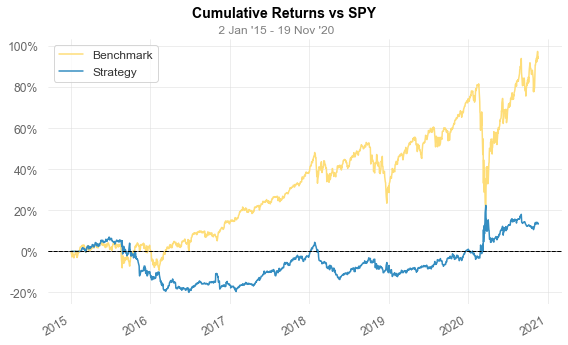

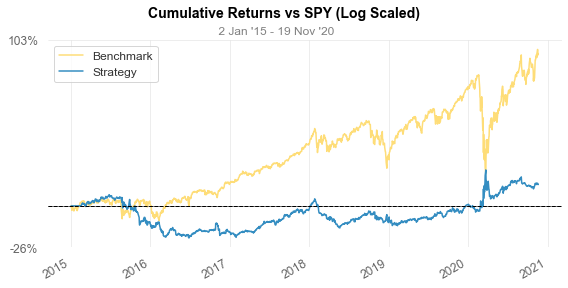

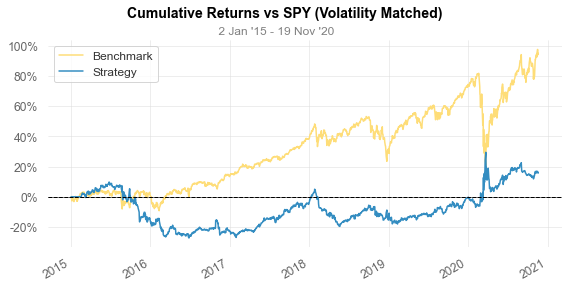

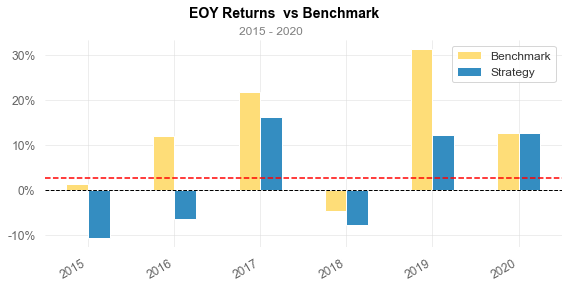

X:\Environments\Backtesting\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


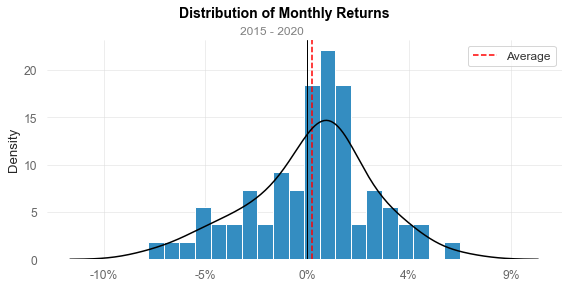

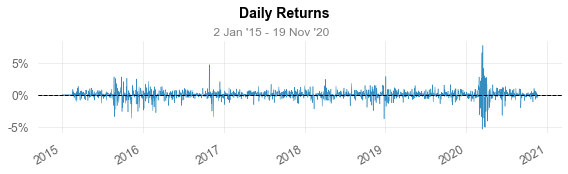

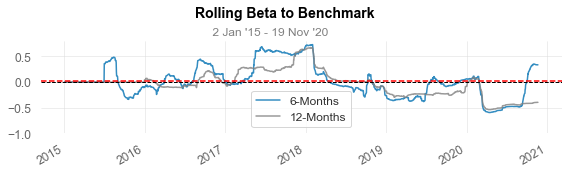

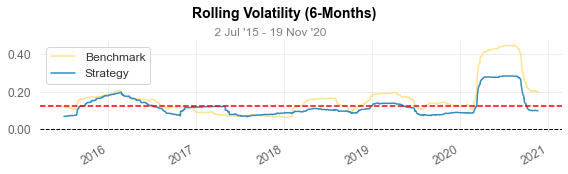

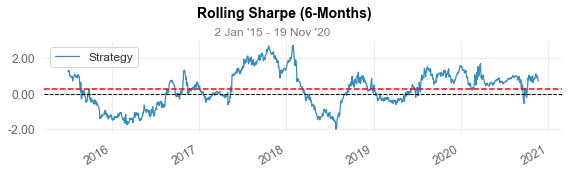

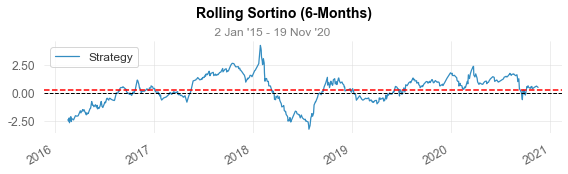

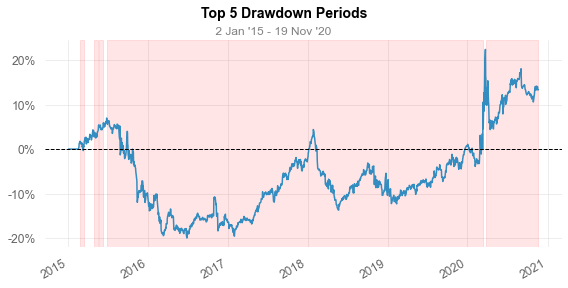

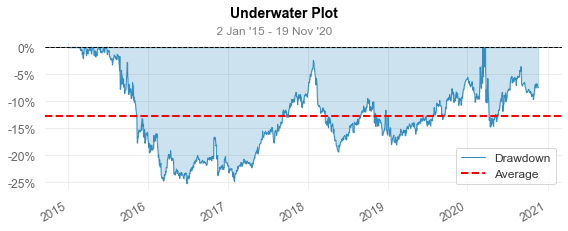

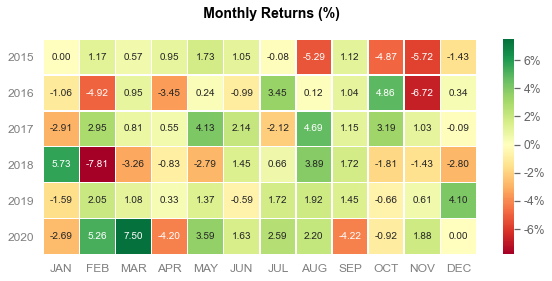

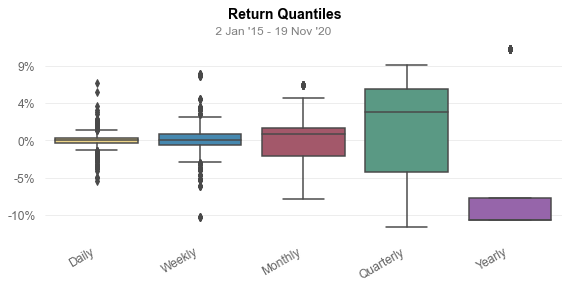

In [20]:
qs.reports.full(returns_qs,"SPY")

Start date,2000-01-03
End date,2020-12-04
Total months,250
,Backtest
Annual return,3.521%
Cumulative returns,106.085%
Annual volatility,8.408%
Sharpe ratio,0.45
Calmar ratio,0.25
Stability,0.95
Max drawdown,-14.193%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.19,2015-08-25,2017-01-30,2018-01-26,634
1,13.03,2007-08-16,2008-05-22,2008-11-20,331
2,12.19,2018-01-26,2019-07-17,2020-03-12,555
3,9.83,2020-03-23,2020-04-17,NaT,NaN
4,9.55,2002-10-09,2004-04-06,2005-09-15,767


X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
X:\Environments\Backtesting\lib\site-packages\pandas\plo

Stress Events,mean,min,max
Lehman,0.05%,-1.49%,1.74%
EZB IR Event,-0.08%,-0.69%,0.90%
Flash Crash,-0.49%,-1.36%,0.68%
Apr14,-0.16%,-2.27%,1.19%
GFC Crash,0.01%,-2.67%,3.24%


X:\Environments\Backtesting\lib\site-packages\pandas\core\arrays\datetimes.py:1099: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
X:\Environments\Backtesting\lib\site-packages\pandas\core\arrays\datetimes.py:1099: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum]

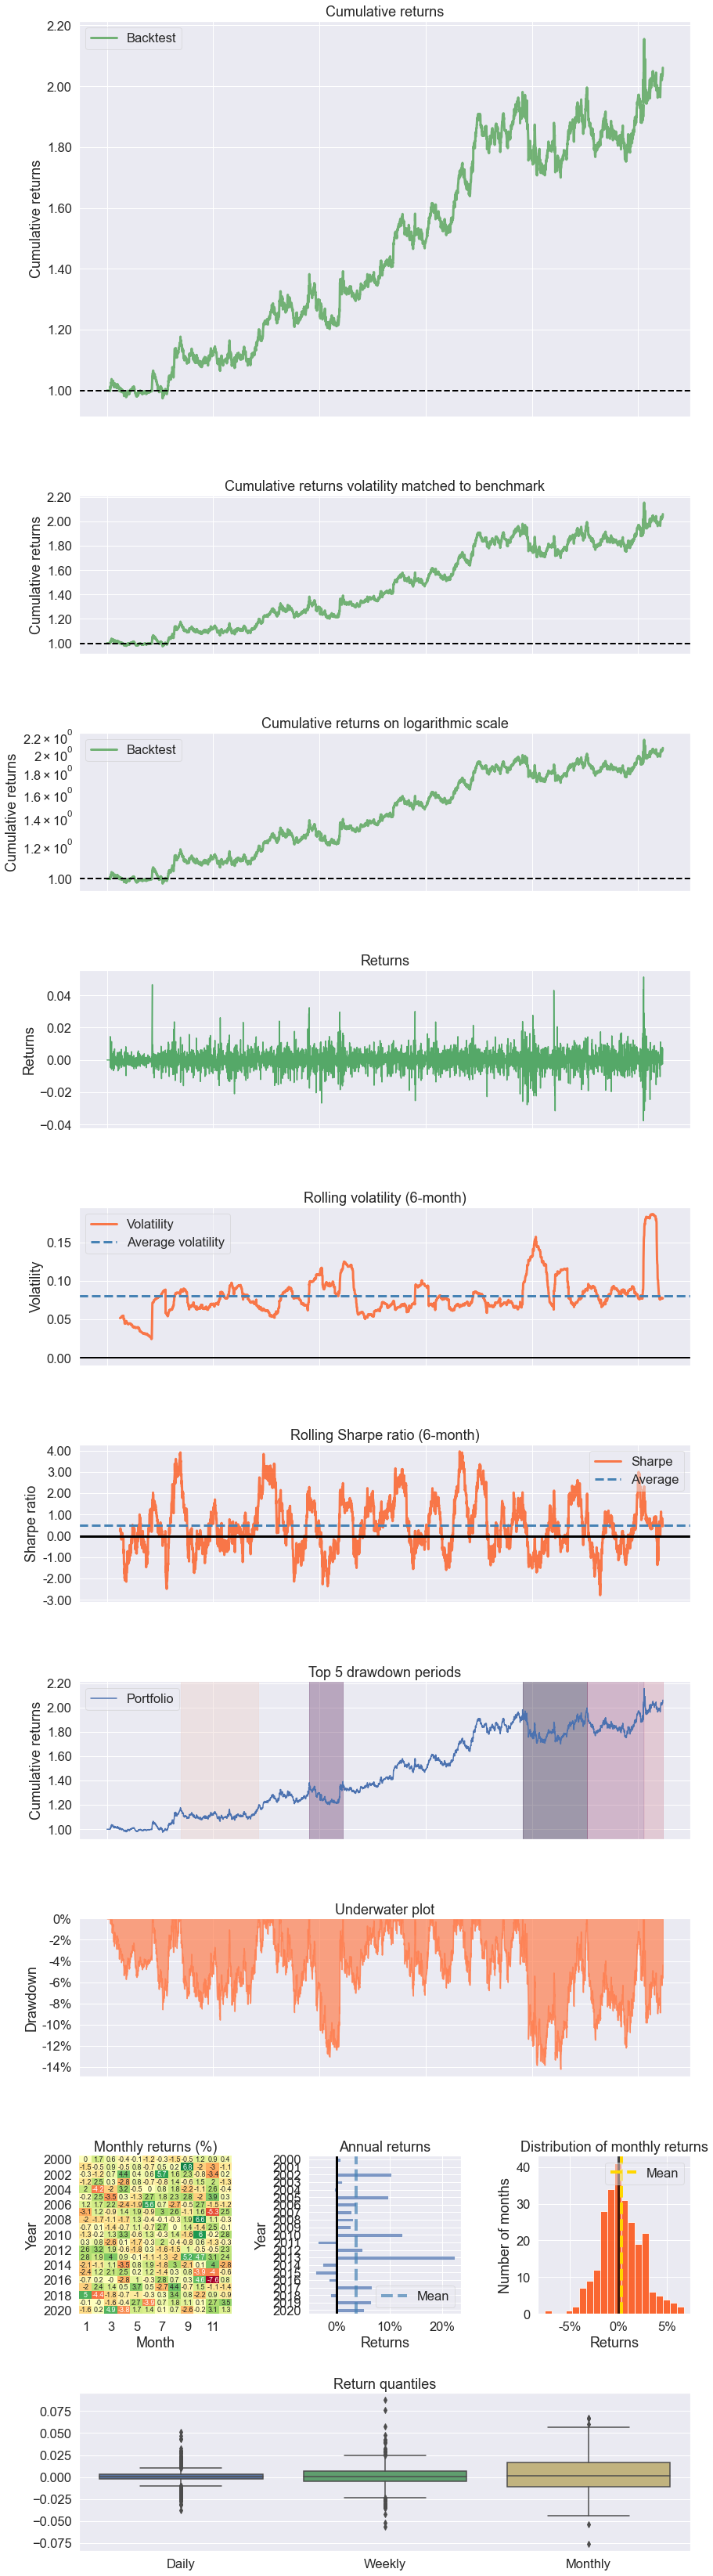

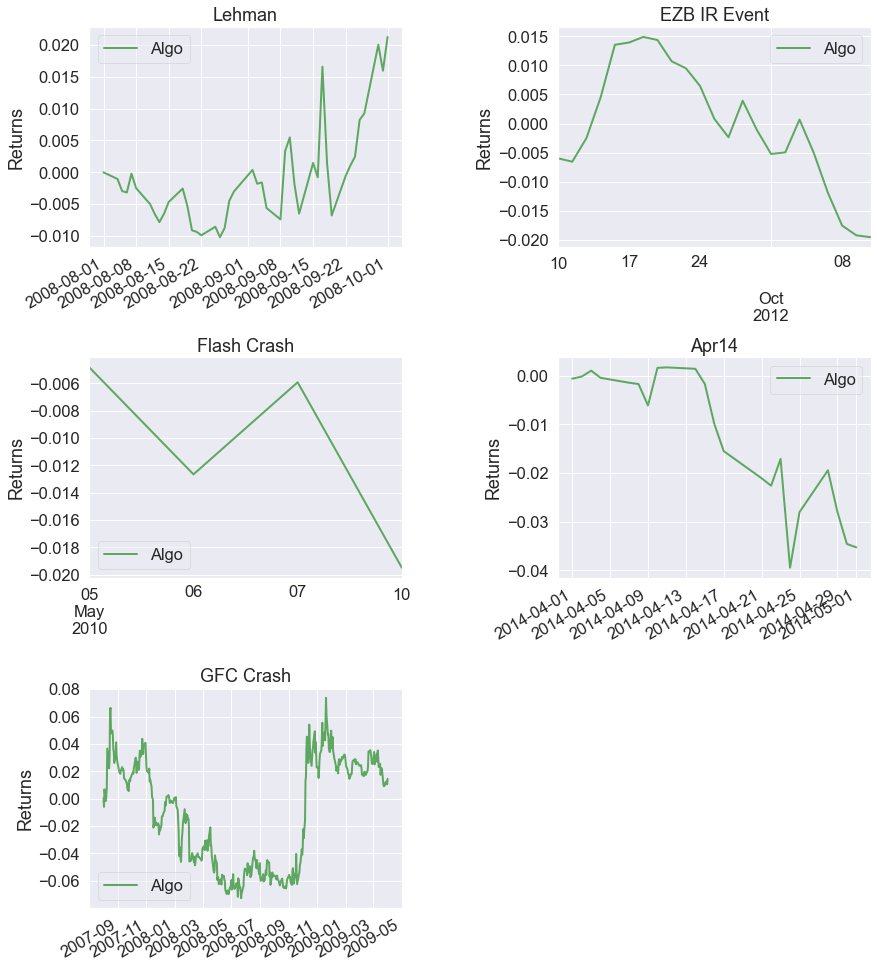

In [48]:
pf.create_full_tear_sheet(returns=returns,transactions=transactions)

In [308]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2018-02-28 23:59:59.999989+00:00,1868,53.346891,2,VEU,-99651.991579
2018-03-29 23:59:59.999989+00:00,6,50.552309,2,VEU,-303.313856
2018-06-29 23:59:59.999989+00:00,361,259.571680,0,SPY,-93705.376637
2018-06-29 23:59:59.999989+00:00,-1874,50.113540,2,VEU,93912.773831
